In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from src.utils import get_dataset, get_cc_mat

### Get data

In [3]:
df = get_dataset(
    labels_file="class_vector_train_ref.mat", 
    params_file="training_set_ref.mat"
)

print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (200000, 259)


,BIO@atp_c,BIO@pyr_c,BIO@nad_c,BIO@g6p_c,BIO@oaa_c,BIO@f6p_c,BIO@nadph_c,BIO@nh4_c,BIO@o2_c,BIO@r5p_c,...,D_LAC@feri_m,D_LAC@lac_m,SUCCt2r@suc_c,MALt2r@mal_c,CITt2m@mal_c,CITt2m@cit_m,CITt2m@mal_m,CITt2m@cit_c,PFK@amp_c,label
0,0.457634,0.014440,0.058212,0.676883,0.341359,0.662601,0.558494,0.469465,0.379688,0.031882,...,0.310612,0.176318,0.750574,0.835077,0.636952,0.805681,0.314653,0.601644,0.442062,s
1,0.011809,0.879388,0.003459,0.746891,0.306732,0.324433,0.790872,0.561433,0.601143,0.729455,...,0.260641,0.480122,0.828887,0.774984,0.793254,0.111233,0.174306,0.035144,0.432545,s
2,0.150170,0.442691,0.029388,0.930178,0.904467,0.690296,0.083225,0.292097,0.122153,0.097039,...,0.780362,0.548510,0.591525,0.579699,0.168482,0.214867,0.430102,0.757192,0.281138,s
3,0.241337,0.108236,0.874900,0.908554,0.945598,0.204189,0.396873,0.474224,0.738103,0.958655,...,0.998683,0.015408,0.362024,0.127115,0.230577,0.996991,0.195371,0.013773,0.316083,s
4,0.357361,0.179095,0.737178,0.371373,0.562450,0.809965,0.920162,0.750900,0.623332,0.356794,...,0.298213,0.555471,0.611591,0.020826,0.543747,0.459455,0.110901,0.838803,0.561902,s


In [137]:
# Value counts of the stability label
df['label'].value_counts(normalize=True).round(4)

label
ns    0.532
s     0.468
Name: proportion, dtype: float64

### FFC

In [138]:
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat('./data/ccXTR_ref.mat')


Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


In [139]:
idx_HXK = commonConCoeff[commonConCoeff['HXK'] < 0].index
df_HXK = df.drop('label', axis=1)
df_HXK['label'] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK['label'].value_counts(normalize=True).round(4)

label
0    0.532
1    0.468
Name: proportion, dtype: float64

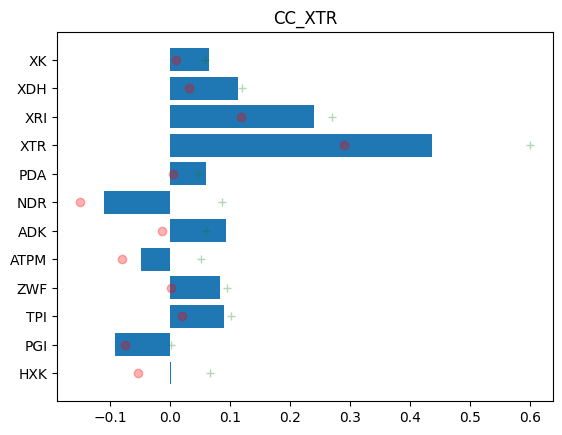

In [140]:
# Calculate the 1st and 3rd quartiles of commonConCoeff values
q1 = commonConCoeff.quantile(0.25)
q3 = commonConCoeff.quantile(0.75)

# Plot the mean of commonConCoeff values
plt.barh(commonConCoeff.columns, commonConCoeff.mean())
plt.plot(q1, commonConCoeff.columns, 'o', color='red', label='Q1', alpha=0.3)
plt.plot(q3, commonConCoeff.columns, '+', color='green', label='Q3', alpha=0.3)
plt.title("CC_XTR")
plt.show()

In [141]:
commonConCoeff[(commonConCoeff['HXK'] <= 1) & (commonConCoeff['HXK'] >= -1)].describe()

,HXK,PGI,TPI,ZWF,ATPM,ADK,NDR,PDA,XTR,XRI,XDH,XK
count,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000,192658.000000
mean,0.006421,-0.054374,0.078306,0.057488,-0.024808,0.035368,-0.047953,0.034773,0.445500,0.209022,0.088310,0.046271
std,0.193140,0.324874,0.183670,0.279520,0.360166,0.239177,0.597332,0.170039,0.242781,0.224174,0.196062,0.127354
min,-0.999784,-50.818626,-17.327398,-28.420590,-39.196526,-7.511426,-47.707120,-13.335763,-23.455957,-15.535572,-15.786498,-10.296060
25%,-0.049871,-0.071807,0.020039,0.003062,-0.076272,-0.011903,-0.141269,0.004655,0.294019,0.119710,0.032458,0.010705
50%,0.004677,-0.024424,0.047748,0.035694,-0.010910,0.012745,-0.017614,0.018608,0.430724,0.182419,0.064095,0.025720
75%,0.062087,0.000075,0.098986,0.090349,0.048036,0.055659,0.082294,0.045055,0.598664,0.263740,0.115883,0.055263
max,0.999932,12.092919,10.937030,26.415066,20.956515,29.665403,29.768644,25.566749,10.902439,23.288314,33.857907,25.838807
